In [ ]:
# Mount the google drive
# Click on the link and sign in to google account. Get the authentication token and enter here
from google.colab import drive

drive.mount('/content/gdrive')

In [ ]:
#cd gdrive

In [ ]:
#Import required libraries
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout ,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam


from keras.models import Model

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

from keras.layers import ZeroPadding2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.layers import GlobalAveragePooling2D, MaxPooling2D
from keras.models import Model, Sequential

In [ ]:
# Define the path where all the training data is stored. 
# Train folder contains sub folder with each class as the name of the folder.
train_dir = 'gdrive/MyDrive/DistractedDriver/imgs/train/'
classes = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']

In [ ]:
# Load csv file
import pandas as pd
driver_imgs_df = pd.read_csv('gdrive/MyDrive/DistractedDriver/driver_imgs_list.csv')

**Pre-processing steps**

In [ ]:
driver_imgs_df.head()


subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

In [ ]:
list = ['c0','c1','c2']
result_df_three_class = driver_imgs_df.loc[driver_imgs_df['classname'].isin(list)]


In [ ]:
N =1000
result_df = result_df_three_class.groupby('classname').head(N).reset_index(drop=True)

In [ ]:
result_df.describe()

subject classname            img
count     3000      3000           3000
unique      10         3           3000
top       p021        c2  img_32157.jpg
freq       393      1000              1

In [ ]:
#result_df['classname'] = result_df['classname'].replace({'c0':'0','c1':'1','c2':'2'})

In [ ]:
result_df.iloc[1]

subject               p002
classname               c0
img          img_72999.jpg
Name: 1, dtype: object

In [ ]:

# Split data into three dataframes train,validate and test respectively.
train, validate, test = np.split(result_df.sample(frac=1, random_state=42), [int(.6*len(result_df)), int(.8*len(result_df))])

In [ ]:

# Get images from the locatio. Image info is present under the 'img' column of one of the three columns in data frame

from keras_preprocessing.image import ImageDataGenerator

# Creating image generator object with rescaling and no augmentation
datagen=ImageDataGenerator(rescale=1./255)

# Getting training data in train generator from 'Train_Images' folder. Passing train dataframe.
# "Train_Images" folder contains images of all the different sub classes/folders.
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory=train_dir+'/Train_Images',
x_col="img",
y_col="classname",
seed=42,
#shuffle=True,
class_mode="categorical",
target_size=(224,224))

# Getting validation data in train generator from 'Train_Images' folder. Passing validate dataframe.
# "Train_Images" folder contains images of all the different sub classes/folders.
validate_generator=datagen.flow_from_dataframe(
dataframe=validate,
directory=train_dir+'/Train_Images',
x_col="img",
y_col="classname",
seed=42,
#shuffle=True,
class_mode="categorical",
target_size=(224,224))


# Getting testing data in train generator from 'Train_Images' folder. Passing test dataframe.
# "Train_Images" folder contains images of all the different sub classes/folders.
test_generator=datagen.flow_from_dataframe(
dataframe=test,
directory=train_dir+'/Train_Images',
x_col="img",
y_col="classname",
seed=42,
#shuffle=True,
class_mode="categorical",
target_size=(224,224))

Found 1800 validated image filenames belonging to 3 classes.
Found 600 validated image filenames belonging to 3 classes.
Found 600 validated image filenames belonging to 3 classes.


In [ ]:
# Function to get the images data from the generator. 
# We can pass any generator : train,test,validate. 
# This function extracts image information.
def get_images_data(batch_size,generator):
    data_list = []
    for i in range(batch_size):
        data = generator.next()
        data_list.append(data[0])
        # classses get       
    return data_list  

In [ ]:
# get test images from test generator object
# Provide batch size. 
batch_s = 6
# Output will be images present for batch size.
test_data_list = get_images_data(batch_s,train_generator)

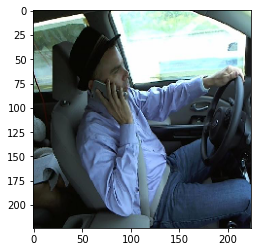

In [ ]:
# To access images of shape (batc_size,img_height,img_width,channelsize), we do test_data[0][0] as test_data[batch number][image number]
plt.imshow(test_data_list[0][0])

In [ ]:


# Building a plain vanilla/choclate/butterscotch cnn model
def build_model():
      input_layer = Input(shape=(224,224, 3))

      conv = Conv2D(filters=8, kernel_size=2)(input_layer)
      conv = Conv2D(filters=16, kernel_size=2, activation='relu')(conv)
      conv = Conv2D(filters=32, kernel_size=2, activation='relu')(conv)
      conv = MaxPooling2D()(conv)

      conv = Conv2D(filters=64, kernel_size=2, activation='relu')(conv)
      conv = Conv2D(filters=128, kernel_size=2, activation='relu')(conv)
      conv = Conv2D(filters=512, kernel_size=2, activation='relu')(conv)

      conv = GlobalAveragePooling2D()(conv)
      dense = Dense(units=500, activation='relu')(conv)
      dense = Dropout(0.1)(dense)
      dense = Dense(units=100, activation='relu')(dense)
      dense = Dropout(0.1)(dense)
      output = Dense(units=3, activation='softmax')(dense)

      model = Model(inputs=input_layer, outputs = output)

      return model

In [ ]:
# Getting model for 1800 images that we got for training.
model_new_1800_imgs = build_model()

In [ ]:
# Compile model with the following params.
model_new_1800_imgs.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [ ]:
# Train model with train generator and provide validate generator as validation data.
# Steps_per_epoch = number of images present in the generator/batch_size
model_new_1800_imgs.fit(train_generator, steps_per_epoch = 1800/32,
                    validation_steps = 600/32,
                         epochs = 10,
                         validation_data = validate_generator)

Epoch 1/10
56/56 [==============================] - 899s 16s/step - loss: 1.1001 - accuracy: 0.3244 - val_loss: 1.0990 - val_accuracy: 0.3417
Epoch 2/10
56/56 [==============================] - 882s 16s/step - loss: 1.0981 - accuracy: 0.3217 - val_loss: 1.0990 - val_accuracy: 0.3150
Epoch 3/10
56/56 [==============================] - 884s 16s/step - loss: 1.0988 - accuracy: 0.3346 - val_loss: 1.0989 - val_accuracy: 0.3167
Epoch 4/10
56/56 [==============================] - 879s 16s/step - loss: 1.0984 - accuracy: 0.3440 - val_loss: 1.0982 - val_accuracy: 0.3550
Epoch 5/10
56/56 [==============================] - 879s 16s/step - loss: 1.0990 - accuracy: 0.3287 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 6/10
56/56 [==============================] - 879s 16s/step - loss: 1.0984 - accuracy: 0.3481 - val_loss: 1.0987 - val_accuracy: 0.3383
Epoch 7/10
56/56 [==============================] - 878s 16s/step - loss: 1.0990 - accuracy: 0.3009 - val_loss: 1.0987 - val_accuracy: 0.3283
Epoch 

In [ ]:
# Saving the model at the required designation
source_dir = 'gdrive/MyDrive/DistractedDriver/'
model_new_1800_imgs.save(source_dir+"model_new_1800_imgs.h5")

In [ ]:
#load keras model
source_dir = 'gdrive/MyDrive/DistractedDriver/'
model_new_1800_imgs = keras.models.load_model(source_dir+'model_new_1800_imgs.h5')

In [ ]:
import sys
# Function to generate the output from the model
# It returns y_pred_list and y_true_list

# Params: 
#       model_object: model that was trained.
#       test_data_list: List that was created above with test images for each bacth that was provided.  
def generat_model_output(model_object,test_data_list):
    y_true_list = np.array([])
    y_pred_list = np.array([])
    #Loop over test images and for each bacth we will predict
    for batch in range(len(test_data_list)):

      # Predict the model for each bacth of images
      predict = model_object.predict(test_data_list[batch])
      # Get the y_pred for it
      y_pred = np.argmax(predict, axis=1)

      #print(y_pred.shape)
      #print(y_pred)
      sys.stdout.flush()

      # For first time we will generate an array after first iteration we will append results in list.
      if len(y_pred_list) == 0:
          y_pred_list = np.array(y_pred)
      else:
          y_pred_list = np.append(y_pred_list, y_pred, axis=0)
      print(type(y_pred))

      if len(y_true_list) == 0:
          y_true_list = np.array(test_generator.classes[0:len(y_pred)])
      else:
          y_true_list = np.append(y_true_list, test_generator.classes[0:len(y_pred)], axis=0)

      #print(y_true_list.shape)    
      #print(y_true_list)
      #y_pred_list.append(y_pred)
      #y_true.append(test_generator.classes[0:len(y_pred)])

      #print(len(y_pred))
      #print(len(test_generator.classes[0:len(y_pred)]))

    return y_pred_list,y_true_list


In [ ]:
# Calling the function to get y_pred_list,y_true_list 
y_pred_list,y_true_list = generat_model_output(model_new_1800_imgs,test_data_list)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
# Creating confusion matrix
confusion_matrix(y_true_list, y_pred_list)

print('Classification Report')
target_names = ['c0', 'c1', 'c2']

report = classification_report(y_true_list, y_pred_list, target_names=target_names,output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)

Classification Report
              precision    recall  f1-score   support
c0             0.000000  0.000000  0.000000   60.0000
c1             0.437500  1.000000  0.608696   84.0000
c2             0.000000  0.000000  0.000000   48.0000
accuracy       0.437500  0.437500  0.437500    0.4375
macro avg      0.145833  0.333333  0.202899  192.0000
weighted avg   0.191406  0.437500  0.266304  192.0000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Mapping_category = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}

(1, 224, 224, 3)
1/1 [==============================] - 0s 141ms/step
[[0.92151576 0.07675165 0.00173258]]
Y Prediction: 0
Predicted as: Safe driving


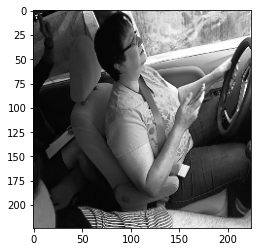

(1, 224, 224, 3)
1/1 [==============================] - 0s 126ms/step
[[9.9994063e-01 3.7214726e-05 2.2207245e-05]]
Y Prediction: 0
Predicted as: Safe driving


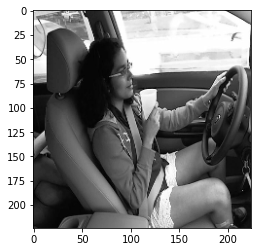

(1, 224, 224, 3)
1/1 [==============================] - 0s 139ms/step
[[8.7084395e-01 4.1532167e-04 1.2874073e-01]]
Y Prediction: 0
Predicted as: Safe driving


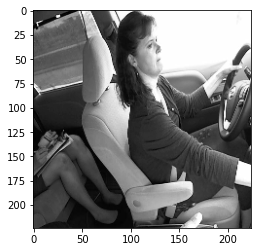

(1, 224, 224, 3)
1/1 [==============================] - 0s 136ms/step
[[0.49663353 0.01525765 0.48810884]]
Y Prediction: 0
Predicted as: Safe driving


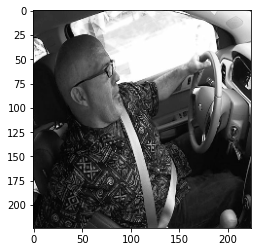

(1, 224, 224, 3)
1/1 [==============================] - 0s 132ms/step
[[0.54473597 0.00487237 0.45039168]]
Y Prediction: 0
Predicted as: Safe driving


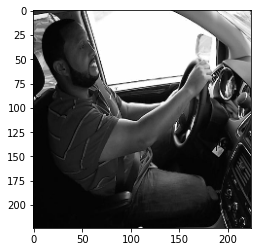

(1, 224, 224, 3)
1/1 [==============================] - 0s 129ms/step
[[9.9936360e-01 6.3369627e-04 2.7645065e-06]]
Y Prediction: 0
Predicted as: Safe driving


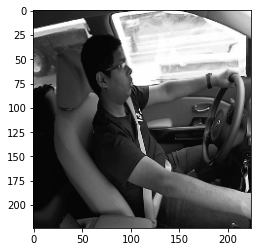

(1, 224, 224, 3)
1/1 [==============================] - 0s 140ms/step
[[3.5562775e-01 6.4434737e-01 2.4982592e-05]]
Y Prediction: 1
Predicted as: Texting - right


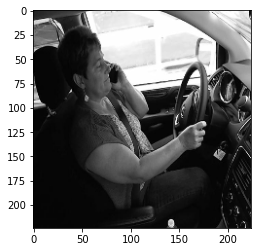

(1, 224, 224, 3)
1/1 [==============================] - 0s 129ms/step
[[9.8916817e-01 3.8111903e-04 1.0450771e-02]]
Y Prediction: 0
Predicted as: Safe driving


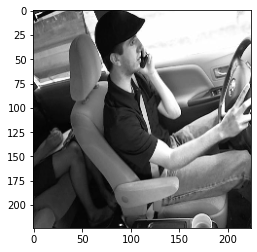

(1, 224, 224, 3)
1/1 [==============================] - 0s 137ms/step
[[0.99547946 0.00200431 0.00251616]]
Y Prediction: 0
Predicted as: Safe driving


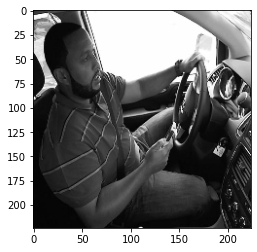

(1, 224, 224, 3)
1/1 [==============================] - 0s 136ms/step
[[1.0640283e-02 4.7388402e-04 9.8888588e-01]]
Y Prediction: 2
Predicted as: Talking on the phone - right


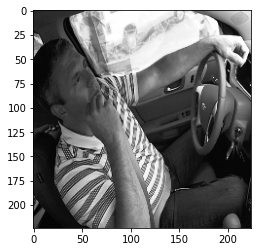

In [ ]:
test_dir = 'gdrive/MyDrive/DistractedDriver/imgs/test'
cnt = 0
for img in os.listdir(test_dir):
  cnt = cnt+1
  img_array = cv2.imread(os.path.join(test_dir,img),cv2.IMREAD_GRAYSCALE)
  img_display = cv2.resize(img_array,(224,224))
  plt.imshow(img_display, cmap='gray')
  
  im = cv2.resize(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB), (224,224)).astype(np.float32) / 255.0
  im = np.expand_dims(im, axis =0)
  print(im.shape)
  y_preds = model_v2.predict(im, batch_size=32, verbose=1)
  print(y_preds)
  y_prediction = np.argmax(y_preds)
  print('Y Prediction: {}'.format(y_prediction))
  print('Predicted as: {}'.format(Mapping_category.get('c{}'.format(y_prediction))))
  plt.show()

  if cnt == 10:
    break
  

VGG16

In [ ]:

from tensorflow.keras.applications import vgg16

# Loading VGG16 model with imagenet pre trained weights.
vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
# Checking layers
for layer in vgg_conv.layers:

    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f35976ff190> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3597704ad0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f35a0e3ee10> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f3597581910> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f35975bfd50> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f35977a0c90> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f3597674690> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f359766c390> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f35977a0950> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f35977a0810> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f359a9e8e50> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3597654

In [ ]:

# freeze all the layers in VGG16 for training.
for layer in vgg_conv.layers[:]:

    layer.trainable = False

for layer in vgg_conv.layers:

    print(layer, layer.trainable)


<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f35976ff190> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3597704ad0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f35a0e3ee10> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f3597581910> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f35975bfd50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f35977a0c90> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f3597674690> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f359766c390> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f35977a0950> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f35977a0810> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f359a9e8e50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

In [ ]:
from keras.layers import ZeroPadding2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.layers import GlobalAveragePooling2D, MaxPooling2D
from keras.models import Model, Sequential

def build_model_fine_tune_vgg(vgg_conv):
      input_layer = Input(shape=(224,224, 3))

      model = Sequential()

      model.add(vgg_conv)

      model.add(Dropout(0.4))

      model.add(Flatten())
      model.add(Dense(128,activation="relu"))
      model.add(Dense(3, activation="softmax"))


      return model

In [ ]:
model_vgg = build_model_fine_tune_vgg(vgg_conv)

In [ ]:
from keras import optimizers

In [ ]:
model_vgg.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'],optimizer=optimizers.SGD(lr=1e-4, momentum=0.9))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#from keras.callbacks import ModelCheckpoint


model_vgg.fit_generator(train_generator, steps_per_epoch = 1800/32,
                    validation_steps = 600/32,
                         epochs = 2,
                         validation_data = validate_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
56/56 [==============================] - 1208s 22s/step - loss: 1.2919 - accuracy: 0.3855 - val_loss: 0.9497 - val_accuracy: 0.3833
Epoch 2/2
56/56 [==============================] - 1206s 22s/step - loss: 0.8042 - accuracy: 0.6760 - val_loss: 0.4920 - val_accuracy: 0.9267


In [ ]:
y_pred_list,y_true_list = generat_model_output(model_vgg,test_data_list)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
confusion_matrix(y_true_list, y_pred_list)

print('Classification Report')
target_names = ['c0', 'c1', 'c2']

report = classification_report(y_true_list, y_pred_list, target_names=target_names,output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)

Classification Report
              precision    recall  f1-score     support
c0             0.301887  0.266667  0.283186   60.000000
c1             0.507937  0.380952  0.435374   84.000000
c2             0.276316  0.437500  0.338710   48.000000
accuracy       0.359375  0.359375  0.359375    0.359375
macro avg      0.362046  0.361706  0.352423  192.000000
weighted avg   0.385641  0.359375  0.363649  192.000000


**CNN Model 2**

In [ ]:
def create_model_v2():
    model = Sequential()

    model.add(Conv2D(32,(3,3),activation='relu',input_shape=(224, 224, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(3,activation='softmax'))

    return model

In [ ]:
model_v2 = create_model_v2()

In [ ]:
model_v2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model_v2.fit_generator(train_generator, steps_per_epoch = 1800/32,
                    validation_steps = 600/32,
                         epochs = 10,
                         validation_data = validate_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
56/56 [==============================] - 786s 14s/step - loss: 0.8667 - accuracy: 0.7283 - val_loss: 3.2766 - val_accuracy: 0.3467
Epoch 2/10
56/56 [==============================] - 776s 14s/step - loss: 0.0608 - accuracy: 0.9787 - val_loss: 3.1954 - val_accuracy: 0.3317
Epoch 3/10
56/56 [==============================] - 783s 14s/step - loss: 0.0373 - accuracy: 0.9920 - val_loss: 1.8332 - val_accuracy: 0.3233
Epoch 4/10
56/56 [==============================] - 788s 14s/step - loss: 0.0415 - accuracy: 0.9782 - val_loss: 1.9951 - val_accuracy: 0.3617
Epoch 5/10
56/56 [==============================] - 772s 14s/step - loss: 0.0141 - accuracy: 0.9969 - val_loss: 1.8149 - val_accuracy: 0.5417
Epoch 6/10
56/56 [==============================] - 777s 14s/step - loss: 0.0167 - accuracy: 0.9941 - val_loss: 1.4301 - val_accuracy: 0.5367
Epoch 7/10
56/56 [==============================] - 777s 14s/step - loss: 0.0081 - accuracy: 0.9977 - val_loss: 2.3882 - val_accuracy: 0.3500
Epoch 

In [ ]:
source_dir = 'gdrive/MyDrive/DistractedDriver/'
model_v2.save(source_dir+"model_v2.h5")

In [ ]:
#load keras model
source_dir = 'gdrive/MyDrive/DistractedDriver/'
model_v2 = keras.models.load_model(source_dir+'model_v2.h5')

In [ ]:
y_pred_list,y_true_list = generat_model_output(model_v2,test_data_list)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
confusion_matrix(y_true_list, y_pred_list)

print('Classification Report')
target_names = ['c0', 'c1', 'c2']

report = classification_report(y_true_list, y_pred_list, target_names=target_names,output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)

Classification Report
              precision    recall  f1-score     support
c0             0.310000  0.516667  0.387500   60.000000
c1             0.512195  0.250000  0.336000   84.000000
c2             0.294118  0.312500  0.303030   48.000000
accuracy       0.348958  0.348958  0.348958    0.348958
macro avg      0.372104  0.359722  0.342177  192.000000
weighted avg   0.394490  0.348958  0.343851  192.000000


In [ ]:
cf_matrix = confusion_matrix(y_true_list, y_pred_list)
print(cf_matrix)

[[31 15 14]
 [41 21 22]
 [28  5 15]]


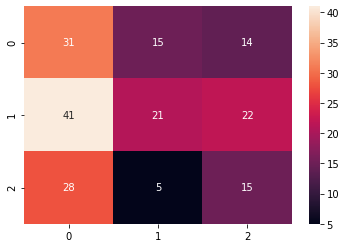

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [ ]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

In [ ]:
acc = accuracy(cf_matrix)

In [ ]:
print(acc)

0.3489583333333333


**Model with less images for each class**

In [ ]:
# Load csv file
import pandas as pd
driver_imgs_df = pd.read_csv('gdrive/MyDrive/DistractedDriver/driver_imgs_list.csv')

In [ ]:
N = 300
result_df = driver_imgs_df.groupby('classname').head(N).reset_index(drop=True)

In [ ]:
result_df.describe()

subject classname            img
count     3000      3000           3000
unique       5        10           3000
top       p014        c8  img_21410.jpg
freq       876       300              1

In [ ]:

# Split data into three dataframes train,validate and test respectively.
train, validate, test = np.split(result_df.sample(frac=1, random_state=42), [int(.6*len(result_df)), int(.8*len(result_df))])

In [ ]:

# Get images from the locatio. Image info is present under the 'img' column of one of the three columns in data frame

from keras_preprocessing.image import ImageDataGenerator

# Creating image generator object with rescaling and no augmentation
datagen=ImageDataGenerator(rescale=1./255)

# Getting training data in train generator from 'Train_Images' folder. Passing train dataframe.
# "Train_Images" folder contains images of all the different sub classes/folders.
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory=train_dir+'/Train_Images',
x_col="img",
y_col="classname",
seed=42,
#shuffle=True,
class_mode="categorical",
target_size=(224,224))

# Getting validation data in train generator from 'Train_Images' folder. Passing validate dataframe.
# "Train_Images" folder contains images of all the different sub classes/folders.
validate_generator=datagen.flow_from_dataframe(
dataframe=validate,
directory=train_dir+'/Train_Images',
x_col="img",
y_col="classname",
seed=42,
#shuffle=True,
class_mode="categorical",
target_size=(224,224))


# Getting testing data in train generator from 'Train_Images' folder. Passing test dataframe.
# "Train_Images" folder contains images of all the different sub classes/folders.
test_generator=datagen.flow_from_dataframe(
dataframe=test,
directory=train_dir+'/Train_Images',
x_col="img",
y_col="classname",
seed=42,
#shuffle=True,
class_mode="categorical",
target_size=(224,224))

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 47 invalid image filename(s) in x_col="img". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 22 invalid image filename(s) in x_col="img". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 1753 validated image filenames belonging to 10 classes.
Found 578 validated image filenames belonging to 10 classes.
Found 583 validated image filenames belonging to 10 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 17 invalid image filename(s) in x_col="img". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
def create_model_v2_ten():
    model = Sequential()

    model.add(Conv2D(32,(3,3),activation='relu',input_shape=(224, 224, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10,activation='softmax'))

    return model

In [ ]:
model_v2_with_ten_classes = create_model_v2_ten()

In [ ]:
model_v2_with_ten_classes.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model_v2_with_ten_classes.fit(train_generator, steps_per_epoch = 1753/32,
                    validation_steps = 578/32,
                         epochs = 10,
                         validation_data = validate_generator)

Epoch 1/10
54/54 [==============================] - 909s 17s/step - loss: 1.5769 - accuracy: 0.5431 - val_loss: 3.4640 - val_accuracy: 0.1159
Epoch 2/10
54/54 [==============================] - 742s 14s/step - loss: 0.1151 - accuracy: 0.9717 - val_loss: 4.3413 - val_accuracy: 0.1159
Epoch 3/10
54/54 [==============================] - 745s 14s/step - loss: 0.0379 - accuracy: 0.9973 - val_loss: 4.7773 - val_accuracy: 0.1782
Epoch 4/10
54/54 [==============================] - 744s 14s/step - loss: 0.0380 - accuracy: 0.9936 - val_loss: 6.6216 - val_accuracy: 0.1194
Epoch 5/10
54/54 [==============================] - 744s 14s/step - loss: 0.0288 - accuracy: 0.9937 - val_loss: 5.6099 - val_accuracy: 0.2405
Epoch 6/10
54/54 [==============================] - 745s 14s/step - loss: 0.0313 - accuracy: 0.9939 - val_loss: 4.7731 - val_accuracy: 0.4516
Epoch 7/10
54/54 [==============================] - 742s 14s/step - loss: 0.0170 - accuracy: 0.9980 - val_loss: 4.9884 - val_accuracy: 0.2561
Epoch 

In [ ]:
source_dir = 'gdrive/MyDrive/DistractedDriver/'
model_v2_with_ten_classes.save(source_dir+"model_v2_with_ten_classes.h5")

(1, 224, 224, 3)
1/1 [==============================] - 1s 946ms/step
[[9.3196088e-04 2.9172201e-05 2.0626578e-05 4.5703924e-05 1.1877023e-02
  2.5931461e-06 9.8688006e-01 1.5478448e-06 2.1081445e-04 4.9633519e-07]]
Y Prediction: 6
Predicted as: Drinking


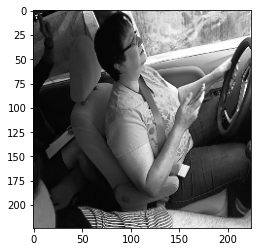

(1, 224, 224, 3)
1/1 [==============================] - 0s 124ms/step
[[7.6852882e-01 4.2796775e-05 1.3403897e-05 5.2995649e-03 1.8327718e-03
  5.8307727e-03 1.7067362e-01 1.7479848e-02 2.9830145e-02 4.6823276e-04]]
Y Prediction: 0
Predicted as: Safe driving


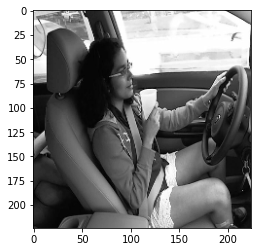

(1, 224, 224, 3)
1/1 [==============================] - 0s 134ms/step
[[3.8196020e-02 1.6484186e-06 4.6004432e-05 5.2662817e-05 7.9862983e-04
  9.4685745e-01 8.7617738e-03 8.5072429e-04 4.1675712e-03 2.6752320e-04]]
Y Prediction: 5
Predicted as: Operating the radio


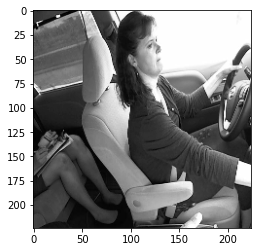

(1, 224, 224, 3)
1/1 [==============================] - 0s 127ms/step
[[8.8449544e-01 8.3591367e-05 2.4198116e-06 5.1098775e-02 1.8180437e-04
  6.9790974e-04 6.8625538e-03 5.5284008e-02 3.0320717e-04 9.9020812e-04]]
Y Prediction: 0
Predicted as: Safe driving


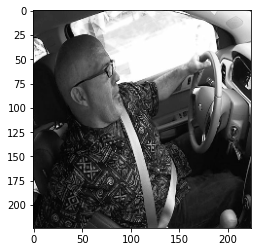

(1, 224, 224, 3)
1/1 [==============================] - 0s 131ms/step
[[8.3651924e-01 1.9189612e-04 1.8376099e-05 1.1896784e-01 4.0979772e-03
  6.4652262e-04 3.0197257e-02 8.9138728e-03 2.7454001e-04 1.7264367e-04]]
Y Prediction: 0
Predicted as: Safe driving


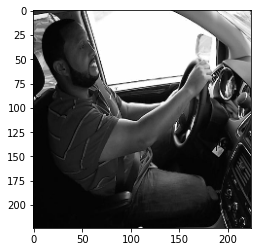

(1, 224, 224, 3)
1/1 [==============================] - 0s 127ms/step
[[8.6433738e-01 2.6839836e-05 4.7650028e-06 6.4898818e-04 4.2132734e-04
  2.5063627e-03 1.2875722e-01 1.7847855e-03 9.8296429e-04 5.2930642e-04]]
Y Prediction: 0
Predicted as: Safe driving


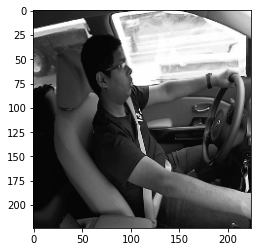

(1, 224, 224, 3)
1/1 [==============================] - 0s 126ms/step
[[7.3148590e-01 4.3895742e-04 2.8235506e-06 2.6332211e-01 6.6016582e-05
  3.1376048e-04 4.0198225e-03 2.8939685e-04 1.2594801e-05 4.8623846e-05]]
Y Prediction: 0
Predicted as: Safe driving


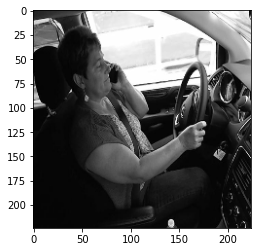

(1, 224, 224, 3)
1/1 [==============================] - 0s 143ms/step
[[2.06801102e-01 4.75863926e-05 4.42310818e-04 1.28965536e-02
  7.47204721e-01 1.32471025e-02 1.68419462e-02 9.72755734e-05
  2.36182380e-03 5.96582540e-05]]
Y Prediction: 4
Predicted as: Talking on the phone - left


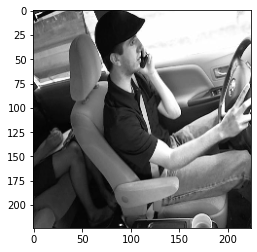

(1, 224, 224, 3)
1/1 [==============================] - 0s 135ms/step
[[3.9748631e-02 5.9935031e-04 5.3691529e-05 7.8781050e-01 2.0716192e-04
  2.4925878e-03 3.7019618e-02 1.3196215e-01 8.1473430e-05 2.4821775e-05]]
Y Prediction: 3
Predicted as: Texting - left


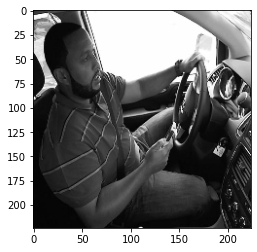

(1, 224, 224, 3)
1/1 [==============================] - 0s 124ms/step
[[7.0438147e-02 7.9550719e-06 1.4338827e-06 6.3847147e-02 3.9815230e-04
  1.7079955e-03 2.5122685e-03 8.6092526e-01 4.9787956e-05 1.1182458e-04]]
Y Prediction: 7
Predicted as: Reaching behind


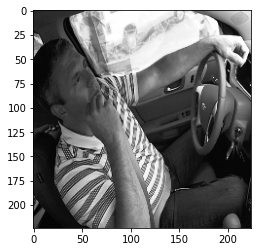

In [ ]:
test_dir = 'gdrive/MyDrive/DistractedDriver/imgs/test'
cnt = 0
for img in os.listdir(test_dir):
  cnt = cnt+1
  img_array = cv2.imread(os.path.join(test_dir,img),cv2.IMREAD_GRAYSCALE)
  img_display = cv2.resize(img_array,(224,224))
  plt.imshow(img_display, cmap='gray')
  
  im = cv2.resize(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB), (224,224)).astype(np.float32) / 255.0
  im = np.expand_dims(im, axis =0)
  print(im.shape)
  y_preds = model_v2_with_ten_classes.predict(im, batch_size=32, verbose=1)
  print(y_preds)
  y_prediction = np.argmax(y_preds)
  print('Y Prediction: {}'.format(y_prediction))
  print('Predicted as: {}'.format(Mapping_category.get('c{}'.format(y_prediction))))
  plt.show()

  if cnt == 10:
    break

In [ ]:
# get test images from test generator object
# Provide batch size. 
batch_s = 6
# Output will be images present for batch size.
test_data_list = get_images_data(batch_s,train_generator)

In [ ]:
len(test_data_list[0])

32

In [ ]:
y_pred_list,y_true_list = generat_model_output(model_v2_with_ten_classes,test_data_list)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
confusion_matrix(y_true_list, y_pred_list)

print('Classification Report')
target_names = ['c0', 'c1', 'c2','c3','c4','c5','c6','c7','c8','c9']

report = classification_report(y_true_list, y_pred_list, target_names=target_names,output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)

Classification Report
              precision    recall  f1-score     support
c0             0.050000  0.500000  0.090909    6.000000
c1             0.000000  0.000000  0.000000   36.000000
c2             0.166667  0.066667  0.095238   30.000000
c3             0.000000  0.000000  0.000000    0.000000
c4             0.130435  0.125000  0.127660   24.000000
c5             0.058824  0.041667  0.048780   24.000000
c6             0.071429  0.166667  0.100000   12.000000
c7             0.000000  0.000000  0.000000    6.000000
c8             0.111111  0.111111  0.111111   18.000000
c9             0.000000  0.000000  0.000000   36.000000
accuracy       0.067708  0.067708  0.067708    0.067708
macro avg      0.058846  0.101111  0.057370  192.000000
weighted avg   0.066142  0.067708  0.056444  192.000000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Model VGG with less images for 10 classes**

In [ ]:

from tensorflow.keras.applications import vgg16

# Loading VGG16 model with imagenet pre trained weights.
vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
# Checking layers
for layer in vgg_conv.layers:

    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9f1bdc6610> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9f2119dd50> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9f1ffa7990> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9f1cc051d0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9f174b0250> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9f1bcbcd50> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9f1fbe7c50> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9f1ff5df10> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9f1cf55d90> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9f1ffa7f90> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9f1ccc8c50> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9f1cc6e

In [ ]:

# freeze all the layers in VGG16 for training.
for layer in vgg_conv.layers[:]:

    layer.trainable = False

for layer in vgg_conv.layers:

    print(layer, layer.trainable)


<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f9f1bdc6610> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9f2119dd50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9f1ffa7990> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9f1cc051d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9f174b0250> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9f1bcbcd50> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9f1fbe7c50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9f1ff5df10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9f1cf55d90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9f1ffa7f90> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f9f1ccc8c50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

In [ ]:
from keras.layers import ZeroPadding2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.layers import GlobalAveragePooling2D, MaxPooling2D
from keras.models import Model, Sequential

def build_model_fine_tune_vgg(vgg_conv):
      input_layer = Input(shape=(224,224, 3))

      model = Sequential()

      model.add(vgg_conv)

      model.add(Dropout(0.4))

      model.add(Flatten())
      model.add(Dense(128,activation="relu"))
      model.add(Dense(10, activation="softmax"))


      return model

In [ ]:
model_vgg_ten_classes = build_model_fine_tune_vgg(vgg_conv)

In [ ]:
from keras import optimizers

In [ ]:
model_vgg_ten_classes.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'],optimizer=optimizers.SGD(lr=1e-4, momentum=0.9))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#from keras.callbacks import ModelCheckpoint


model_vgg_ten_classes.fit(train_generator, steps_per_epoch = 1753/32,
                    validation_steps = 578/32,
                         epochs = 2,
                         validation_data = validate_generator)

Epoch 1/2
54/54 [==============================] - 1190s 22s/step - loss: 2.4786 - accuracy: 0.1328 - val_loss: 1.9621 - val_accuracy: 0.5138
Epoch 2/2
54/54 [==============================] - 1178s 22s/step - loss: 1.9446 - accuracy: 0.3442 - val_loss: 1.4383 - val_accuracy: 0.7751


(1, 224, 224, 3)
1/1 [==============================] - 1s 780ms/step
[[0.10317537 0.1615649  0.08193666 0.05376333 0.03785177 0.07564321
  0.09937866 0.15602547 0.07303283 0.15762775]]
Y Prediction: 1
Predicted as: Texting - right


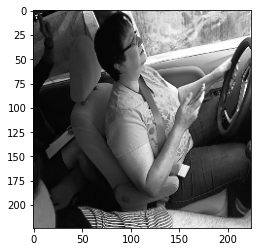

(1, 224, 224, 3)
1/1 [==============================] - 1s 567ms/step
[[0.08177275 0.07694861 0.06899325 0.06351546 0.07731874 0.0992614
  0.06511787 0.17368656 0.13706338 0.15632202]]
Y Prediction: 7
Predicted as: Reaching behind


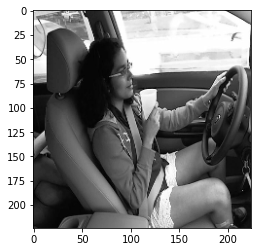

(1, 224, 224, 3)
1/1 [==============================] - 1s 537ms/step
[[0.0582561  0.05832824 0.05927461 0.06775372 0.1536079  0.14453655
  0.16959547 0.11979168 0.12240748 0.04644816]]
Y Prediction: 6
Predicted as: Drinking


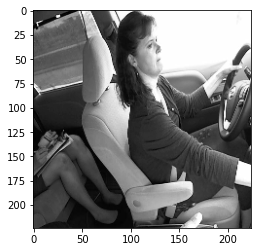

(1, 224, 224, 3)
1/1 [==============================] - 1s 574ms/step
[[0.06722514 0.07478613 0.11322192 0.04415327 0.02716084 0.10962048
  0.1105905  0.22616905 0.10456347 0.1225092 ]]
Y Prediction: 7
Predicted as: Reaching behind


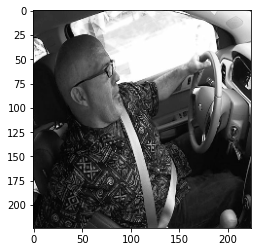

(1, 224, 224, 3)
1/1 [==============================] - 1s 561ms/step
[[0.09919664 0.076619   0.10107712 0.13446017 0.03294021 0.15060984
  0.17059538 0.08698837 0.08531581 0.06219747]]
Y Prediction: 6
Predicted as: Drinking


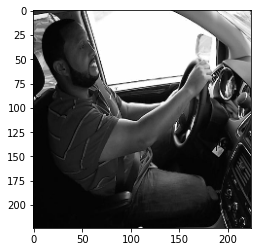

(1, 224, 224, 3)
1/1 [==============================] - 1s 555ms/step
[[0.18305768 0.06350296 0.13497181 0.06745575 0.05061712 0.08282831
  0.08118996 0.117669   0.13982634 0.07888107]]
Y Prediction: 0
Predicted as: Safe driving


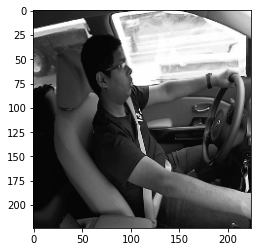

(1, 224, 224, 3)
1/1 [==============================] - 1s 543ms/step
[[0.10405244 0.09828585 0.06498214 0.10568186 0.09060998 0.15864865
  0.13688968 0.09115551 0.07890503 0.07078883]]
Y Prediction: 5
Predicted as: Operating the radio


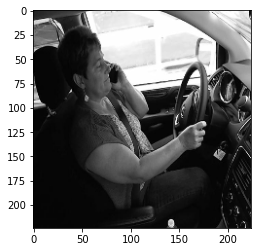

(1, 224, 224, 3)
1/1 [==============================] - 1s 549ms/step
[[0.14539933 0.04003751 0.03208681 0.09798972 0.11419645 0.12486687
  0.07298481 0.14892428 0.1366314  0.08688284]]
Y Prediction: 7
Predicted as: Reaching behind


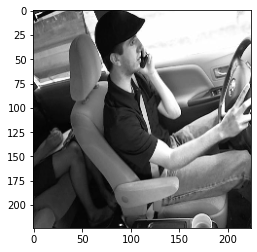

(1, 224, 224, 3)
1/1 [==============================] - 1s 551ms/step
[[0.07252402 0.13053893 0.13429673 0.09851833 0.04363649 0.13403109
  0.09787887 0.10189748 0.11079908 0.07587899]]
Y Prediction: 2
Predicted as: Talking on the phone - right


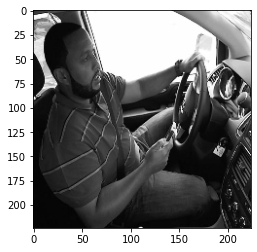

(1, 224, 224, 3)
1/1 [==============================] - 1s 569ms/step
[[0.06372162 0.09963498 0.16565394 0.06107877 0.04854099 0.08460195
  0.06750168 0.07995096 0.14901252 0.18030262]]
Y Prediction: 9
Predicted as: Talking to passenger


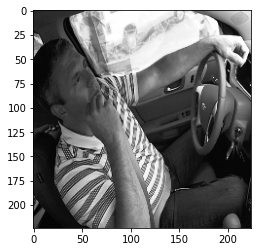

In [ ]:
test_dir = 'gdrive/MyDrive/DistractedDriver/imgs/test'
cnt = 0
for img in os.listdir(test_dir):
  cnt = cnt+1
  img_array = cv2.imread(os.path.join(test_dir,img),cv2.IMREAD_GRAYSCALE)
  img_display = cv2.resize(img_array,(224,224))
  plt.imshow(img_display, cmap='gray')
  
  im = cv2.resize(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB), (224,224)).astype(np.float32) / 255.0
  im = np.expand_dims(im, axis =0)
  print(im.shape)
  y_preds = model_vgg_ten_classes.predict(im, batch_size=32, verbose=1)
  print(y_preds)
  y_prediction = np.argmax(y_preds)
  print('Y Prediction: {}'.format(y_prediction))
  print('Predicted as: {}'.format(Mapping_category.get('c{}'.format(y_prediction))))
  plt.show()

  if cnt == 10:
    break

In [ ]:
y_pred_list,y_true_list = generat_model_output(model_vgg_ten_classes,test_data_list)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
cf_matrix = confusion_matrix(y_true_list, y_pred_list)
print(cf_matrix)

[[1 0 1 0 0 1 0 0 2 1]
 [5 0 3 4 7 2 5 4 0 6]
 [5 0 2 1 1 4 6 4 4 3]
 [0 0 0 0 0 0 0 0 0 0]
 [6 0 2 0 3 3 4 1 1 4]
 [4 2 0 3 3 1 4 5 2 0]
 [2 0 3 1 0 1 1 0 1 3]
 [1 0 1 0 2 1 0 0 1 0]
 [3 0 3 0 2 0 2 5 1 2]
 [2 2 3 1 6 5 4 8 2 3]]


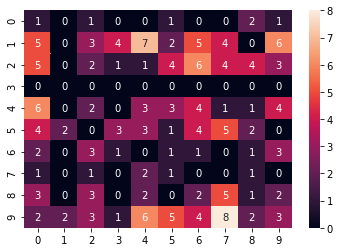

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [ ]:
confusion_matrix(y_true_list, y_pred_list)

print('Classification Report')
target_names = ['c0', 'c1', 'c2','c3','c4','c5','c6','c7','c8','c9']

report = classification_report(y_true_list, y_pred_list, target_names=target_names,output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)

Classification Report
              precision    recall  f1-score   support
c0             0.034483  0.166667  0.057143    6.0000
c1             0.000000  0.000000  0.000000   36.0000
c2             0.111111  0.066667  0.083333   30.0000
c3             0.000000  0.000000  0.000000    0.0000
c4             0.125000  0.125000  0.125000   24.0000
c5             0.055556  0.041667  0.047619   24.0000
c6             0.038462  0.083333  0.052632   12.0000
c7             0.000000  0.000000  0.000000    6.0000
c8             0.071429  0.055556  0.062500   18.0000
c9             0.136364  0.083333  0.103448   36.0000
accuracy       0.062500  0.062500  0.062500    0.0625
macro avg      0.057240  0.062222  0.053168  192.0000
weighted avg   0.075677  0.062500  0.064929  192.0000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**One model with entire data**

In [ ]:
# Load csv file
import pandas as pd
driver_imgs_df = pd.read_csv('gdrive/MyDrive/DistractedDriver/driver_imgs_list.csv')

**Pre-processing steps**

In [ ]:
driver_imgs_df.head()

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

In [ ]:
train_full, validate_full, test_full = np.split(driver_imgs_df.sample(frac=1, random_state=42), [int(.6*len(driver_imgs_df)), int(.8*len(driver_imgs_df))])

In [ ]:
print(train_full.shape)

(13454, 3)


In [ ]:
from keras_preprocessing.image import ImageDataGenerator
datagen=ImageDataGenerator(rescale=1./255)

train_generator=datagen.flow_from_dataframe(
dataframe=train_full,
directory=train_dir+'/Train_Images',
x_col="img",
y_col="classname",
seed=42,
batch_size=32,
#shuffle=True,
class_mode="categorical",
target_size=(224,224))

validate_generator=datagen.flow_from_dataframe(
dataframe=validate_full,
directory=train_dir+'/Train_Images',
x_col="img",
y_col="classname",
seed=42,
batch_size=32,
#shuffle=True,
class_mode="categorical",
target_size=(224,224))


test_generator=datagen.flow_from_dataframe(
dataframe=test_full,
directory=train_dir+'/Train_Images',
x_col="img",
y_col="classname",
seed=42,
batch_size=32,
#shuffle=True,
class_mode="categorical",
target_size=(224,224))

NameError: ignored

In [ ]:
def get_images_data(batch_size,generator):
    data_list = []
    for i in range(batch_size):
        data = generator.next()
        data_list.append(data[0])
        # classses get       
    return data_list  

In [ ]:
# get test images from test generator object
batch_s = 6
test_data_list = get_images_data(batch_s,train_generator)

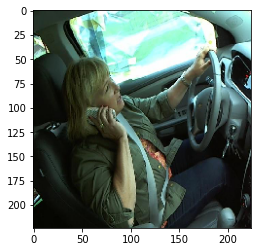

In [ ]:
plt.imshow(test_data_list[0][0])

In [ ]:

from tensorflow.keras.applications import vgg16

vgg_conv_full = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
from keras.layers import ZeroPadding2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.layers import GlobalAveragePooling2D, MaxPooling2D
from keras.models import Model, Sequential

def build_model_fine_tune_vgg_new(vgg_conv):
      input_layer = Input(shape=(224,224, 3))

      model = Sequential()

      model.add(vgg_conv)

      model.add(Dropout(0.4))

      model.add(Flatten())
      model.add(Dense(128,activation="relu"))
      model.add(Dense(4, activation="softmax"))


      return model

In [ ]:
model_vgg_full = build_model_fine_tune_vgg_new(vgg_conv_full)

In [ ]:
from keras import optimizers

In [ ]:
model_vgg_full.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'],optimizer=optimizers.SGD(lr=1e-4, momentum=0.9))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model_vgg_full.fit(train_generator, steps_per_epoch = 5257 /32,
                    validation_steps = 1758 /32,
                         epochs = 2,batch_size = 16,
                         validation_data = validate_generator)

Epoch 1/2
116/164 [====================>.........] - ETA: 49:35 - loss: 1.3520 - accuracy: 0.4120

UnknownError: ignored

In [ ]:
from sklearn.model_selection import train_test_split

xtrain,xtest,ytrain,ytest = train_test_split(result_df.iloc[:,2],result_df['classname'],test_size = 0.2,random_state=42)

In [ ]:
xtrain.iloc[0]

'img_21329.jpg'

In [ ]:
print(xtrain.shape)

(2400,)


In [ ]:
img_path = train_dir+'Train_Images/'+'img_21329.jpg'
#print("Image",img_path)
img = keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
# convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
x = image.img_to_array(img)

print(x.shape)

print(np.expand_dims(x, axis=0).shape)

(224, 224, 3)
(1, 224, 224, 3)


In [ ]:
# Code to get image tensors (**)
from keras.preprocessing import image 
from tensorflow.keras.preprocessing.image import load_img, img_to_array 

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    print(img_path)
    img_path = train_dir+'Train_Images/'+img_path
    #print("Image",img_path)
    img = keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    print(type(x))
    # convert 3D tensor to 4D tensor with shape (1, 224,224, 3) and return 4D tensor
    #print("a",type(np.expand_dims(x, axis=0)))
    #return np.expand_dims(x, axis=0)
    return x

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
#type(xtrain)

In [ ]:
#xtrain = np.asarray(xtrain)

In [ ]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(xtrain).astype('float32')/255 - 0.5


  0%|          | 0/2400 [00:00<?, ?it/s]

img_21329.jpg


AttributeError: ignored

In [ ]:
type(train_tensors)

numpy.ndarray

In [ ]:
valid_tensors = paths_to_tensor(xtest).astype('float32')/255 - 0.5

In [ ]:
img = keras.preprocessing.image.load_img('gdrive/MyDrive/DistractedDriver/imgs/train/Train_Images/img_21329.jpg', target_size=(64, 64))

In [ ]:
train, validate, test = np.split(result_df.sample(frac=1, random_state=42), [int(.6*len(result_df)), int(.8*len(result_df))])

In [ ]:
train.shape

(1800, 3)

In [ ]:
train[:3]

subject classname            img
1801    p022         0  img_58093.jpg
1190    p016         1  img_27386.jpg
1817    p022         0  img_58710.jpg

Found 31237 images belonging to 11 classes.


Found 1800 validated image filenames belonging to 3 classes.
Found 600 validated image filenames belonging to 3 classes.
Found 600 validated image filenames belonging to 3 classes.


In [ ]:
model.su

In [ ]:
model_new_1800_imgs = build_model()

In [ ]:
model_new_1800_imgs.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [ ]:
print(train_tensors.shape)
print(ytrain.shape)

In [ ]:
model_history = model_new_1800_imgs.fit(train_tensors,ytrain,validation_data = (valid_tensors,ytest),epochs=25,batch_size=8)

ValueError: ignored

In [ ]:
model_new_1800_imgs.fit_generator(train_generator, steps_per_epoch = 900/32,
                    validation_steps = 300/32,
                         epochs = 10,
                         validation_data = validate_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
56/56 [==============================] - 977s 17s/step - loss: 1.5968 - accuracy: 0.3143 - val_loss: 1.0977 - val_accuracy: 0.3533
Epoch 2/10
56/56 [==============================] - 895s 16s/step - loss: 1.0997 - accuracy: 0.3300 - val_loss: 1.0964 - val_accuracy: 0.3400
Epoch 3/10
56/56 [==============================] - 894s 16s/step - loss: 1.0952 - accuracy: 0.3599 - val_loss: 1.0658 - val_accuracy: 0.4333
Epoch 4/10
56/56 [==============================] - 894s 16s/step - loss: 1.0752 - accuracy: 0.3887 - val_loss: 1.1070 - val_accuracy: 0.3433
Epoch 5/10
56/56 [==============================] - 899s 16s/step - loss: 1.0879 - accuracy: 0.3784 - val_loss: 1.0598 - val_accuracy: 0.4517
Epoch 6/10
56/56 [==============================] - 907s 16s/step - loss: 0.9956 - accuracy: 0.4927 - val_loss: 1.1568 - val_accuracy: 0.3533
Epoch 7/10
56/56 [==============================] - 902s 16s/step - loss: 1.0282 - accuracy: 0.4557 - val_loss: 0.8220 - val_accuracy: 0.5800
Epoch 

In [ ]:
def get_test_images_data(batch_size,generator):
    data_list = []
    for i in range(batch_size):
        data = generator.next()
        data_list.append(data[0])
        # classses get       
    return data_list  

In [ ]:
# get test images from test generator object
batch_s = 6
test_data_list = get_test_images_data(batch_s,train_generator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


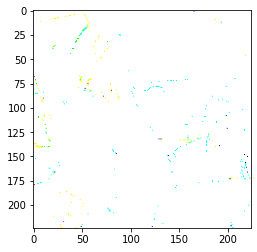

In [ ]:
plt.imshow(test_data_list[0][0])

In [ ]:
import sys
def generat_model_output(model_object,test_data_list):
    y_true_list = np.array([])
    y_pred_list = np.array([])
    for batch in range(len(test_data_list)):

      predict = model_object.predict(test_data_list[batch])
      y_pred = np.argmax(predict, axis=1)

      print(y_pred.shape)
      print(y_pred)
      sys.stdout.flush()
      if len(y_pred_list) == 0:
          y_pred_list = np.array(y_pred)
      else:
          y_pred_list = np.append(y_pred_list, y_pred, axis=0)
      print(type(y_pred))

      if len(y_true_list) == 0:
          y_true_list = np.array(test_generator.classes[0:len(y_pred)])
      else:
          y_true_list = np.append(y_true_list, test_generator.classes[0:len(y_pred)], axis=0)

      print(y_true_list.shape)    
      print(y_true_list)
      #y_pred_list.append(y_pred)
      #y_true.append(test_generator.classes[0:len(y_pred)])

      #print(len(y_pred))
      #print(len(test_generator.classes[0:len(y_pred)]))

    return y_pred_list,y_true_list


In [ ]:
y_pred_list,y_true_list = generat_model_output(model_vgg,test_data_list)

(32,)
[2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
<class 'numpy.ndarray'>
(32,)
[1 0 1 1 0 1 1 2 1 1 1 1 0 1 0 2 2 0 1 2 1 2 0 2 2 1 0 1 0 0 0 2]
(32,)
[2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
<class 'numpy.ndarray'>
(64,)
[1 0 1 1 0 1 1 2 1 1 1 1 0 1 0 2 2 0 1 2 1 2 0 2 2 1 0 1 0 0 0 2 1 0 1 1 0
 1 1 2 1 1 1 1 0 1 0 2 2 0 1 2 1 2 0 2 2 1 0 1 0 0 0 2]
(32,)
[2 2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1]
<class 'numpy.ndarray'>
(96,)
[1 0 1 1 0 1 1 2 1 1 1 1 0 1 0 2 2 0 1 2 1 2 0 2 2 1 0 1 0 0 0 2 1 0 1 1 0
 1 1 2 1 1 1 1 0 1 0 2 2 0 1 2 1 2 0 2 2 1 0 1 0 0 0 2 1 0 1 1 0 1 1 2 1 1
 1 1 0 1 0 2 2 0 1 2 1 2 0 2 2 1 0 1 0 0 0 2]
(32,)
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 1 2]
<class 'numpy.ndarray'>
(128,)
[1 0 1 1 0 1 1 2 1 1 1 1 0 1 0 2 2 0 1 2 1 2 0 2 2 1 0 1 0 0 0 2 1 0 1 1 0
 1 1 2 1 1 1 1 0 1 0 2 2 0 1 2 1 2 0 2 2 1 0 1 0 0 0 2 1 0 1 1 0 1 1 2 1 1
 1 1 0 1 0 2 2 0 1 2 1 2 0 2 2 1 0 1 0 0 0 2 1 0

KeyboardInterrupt: ignored

In [ ]:
confusion_matrix(y_true_list, y_pred_list)

print('Classification Report')
target_names = ['c0', 'c1', 'c2']

report = classification_report(y_true_list, y_pred_list, target_names=target_names,output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)

Classification Report
              precision    recall  f1-score     support
c0             0.338983  0.333333  0.336134   60.000000
c1             0.449275  0.369048  0.405229   84.000000
c2             0.218750  0.291667  0.250000   48.000000
accuracy       0.338542  0.338542  0.338542    0.338542
macro avg      0.335669  0.331349  0.330454  192.000000
weighted avg   0.357178  0.338542  0.344830  192.000000


In [ ]:
out_path = r"gdrive/MyDrive/DistractedDriver/Output/Output_distracted_driver.xlsx"

In [ ]:
with pd.ExcelWriter(out_path) as writer:  
    df_report.to_excel(writer, sheet_name='model_new_1800_imgs')


**Transfer Learning . . . Fine tuning VGG16**

---



---



In [ ]:

from tensorflow.keras.applications import vgg16

vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
for layer in vgg_conv.layers:

    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fd81423a710> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd81423ac90> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd814238dd0> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fd814234cd0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd814226b90> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd814314290> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fd8142fca50> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd8142eea50> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd8142ea890> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd8142f8fd0> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fd8142ee4d0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd814308

In [ ]:

# freeze all the layers in VGG16 for training.
for layer in vgg_conv.layers[:]:

    layer.trainable = False

for layer in vgg_conv.layers:

    print(layer, layer.trainable)


<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f35a0d52a90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f35a0d52510> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f35a1052590> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f35a10bfc10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f35a0d52f10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f35a0d3cb50> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f35a0cc14d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f35a0cca510> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f35a0d52c10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f35a0ccaad0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f35a0cdc590> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

In [ ]:
from keras.layers import ZeroPadding2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.layers import GlobalAveragePooling2D, MaxPooling2D
from keras.models import Model, Sequential

def build_model_fine_tune_vgg(vgg_conv):
      input_layer = Input(shape=(224,224, 3))

      model = Sequential()

      model.add(vgg_conv)

      model.add(Dropout(0.4))

      model.add(Flatten())
      model.add(Dense(128,activation="relu"))
      model.add(Dense(3, activation="softmax"))


      return model

In [ ]:
model_vgg = build_model_fine_tune_vgg(vgg_conv)

In [ ]:
from keras import optimizers

In [ ]:
model_vgg.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'],optimizer=optimizers.SGD(lr=1e-4, momentum=0.9))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model_vgg.fit(train_tensors,ytrain,validation_data = (valid_tensors, ytest),epochs=25, batch_size=40, shuffle=True)

Epoch 1/25


ValueError: ignored

In [ ]:
#from keras.callbacks import ModelCheckpoint


model_vgg.fit_generator(train_generator, steps_per_epoch = 1800/32,
                    validation_steps = 600/32,
                         epochs = 6,
                         validation_data = validate_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/6
56/56 [==============================] - 2042s 36s/step - loss: 4.8145 - accuracy: 0.5498 - val_loss: 0.5868 - val_accuracy: 0.7133
Epoch 2/6
56/56 [==============================] - 2026s 36s/step - loss: 0.5493 - accuracy: 0.7710 - val_loss: 0.0433 - val_accuracy: 0.9883
Epoch 3/6
 2/56 [>.............................] - ETA: 27:51 - loss: 0.0712 - accuracy: 0.9844

KeyboardInterrupt: ignored

In [ ]:
model_vgg

In [ ]:
score, acc = model_vgg.evaluate(x_test, y_test,
                            batch_size=batch_size)

In [ ]:
source_dir = 'gdrive/MyDrive/DistractedDriver/'
model_vgg.save(source_dir+"model_vgg.h5")

NotImplementedError: ignored

In [ ]:
#load keras model
source_dir = 'gdrive/MyDrive/DistractedDriver/'
model_new = keras.models.load_model(source_dir+'first_model.h5')

In [ ]:
from tensorflow.keras import layers
model = keras.Sequential()



model.add(model_vgg)
model.add(layers.Conv2D(32, 5, strides=2, activation="relu",input_shape=model_vgg.output_shape[1:]))
model.add(layers.Conv2D(32, 3, activation="relu"))
model.add(layers.MaxPooling2D(3))

model.add(layers.Conv2D(64, 3, activation="relu"))
model.add(layers.Conv2D(128, 3, activation="relu"))
model.add(layers.MaxPooling2D(3))
model.add(layers.Conv2D(256, 3, activation="relu"))
model.add(layers.Conv2D(512, 3, activation="relu"))
model.add(layers.MaxPooling2D(2))


model.add(layers.ZeroPadding2D((1, 1)))
model.add(layers.Convolution2D(512, 3, 3, padding="same",activation='relu'))
model.add(layers.ZeroPadding2D((1, 1)))
model.add(layers.Convolution2D(512, 3, 3, padding="same",activation='relu'))
model.add(layers.ZeroPadding2D((1, 1)))
model.add(layers.Convolution2D(512, 3, 3, padding="same",activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))


In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.fit_generator(train_generator, steps_per_epoch = 1800/32,
                    validation_steps = 600/32,
                         epochs = 10,
                         validation_data = validate_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


ValueError: ignored

In [ ]:
y_pred_list,y_true_list = generat_model_output(model,test_data_list)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
y_true_list[:-1]

array([1, 0, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 0, 1, 0, 2, 2, 0, 1, 2, 1, 2,
       0, 2, 2, 1, 0, 1, 0, 0, 0, 2, 1, 0, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1,
       0, 1, 0, 2, 2, 0, 1, 2, 1, 2, 0, 2, 2, 1, 0, 1, 0, 0, 0, 2, 1, 0,
       1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 0, 1, 0, 2, 2, 0, 1, 2, 1, 2, 0, 2,
       2, 1, 0, 1, 0, 0, 0, 2, 1, 0, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 0, 1,
       0, 2, 2, 0, 1, 2, 1, 2, 0, 2, 2, 1, 0, 1, 0, 0, 0, 2, 1, 0, 1, 1,
       0, 1, 1, 2, 1, 1, 1, 1, 0, 1, 0, 2, 2, 0, 1, 2, 1, 2, 0, 2, 2, 1,
       0, 1, 0, 0, 0, 2, 1, 0, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 0, 1, 0, 2,
       2, 0, 1, 2, 1, 2, 0, 2, 2, 1, 0, 1, 0, 0, 0])

In [ ]:
confusion_matrix(y_true_list, y_pred_list)

print('Classification Report')
target_names = ['c0', 'c1', 'c2']

report = classification_report(y_true_list, y_pred_list, target_names=target_names,output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)

Classification Report
              precision    recall  f1-score   support
c0             0.000000  0.000000  0.000000   60.0000
c1             0.437500  1.000000  0.608696   84.0000
c2             0.000000  0.000000  0.000000   48.0000
accuracy       0.437500  0.437500  0.437500    0.4375
macro avg      0.145833  0.333333  0.202899  192.0000
weighted avg   0.191406  0.437500  0.266304  192.0000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Load a convolutional base with pre-trained weights
base_model = vgg16.VGG16(weights='imagenet', include_top=False)
 
# Freeze the base model
base_model.trainable = False
 
# Use a Sequential model to add a trainable classifier on top
model_transfer = keras.Sequential([
    base_model,
    layers.Conv2D(32, 5, strides=2, activation="relu",input_shape = (224,224,3)),
    layers.Dense(1000),
])
 

In [ ]:
model_transfer.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model_transfer.fit_generator(train_generator, steps_per_epoch = 1800/32,
                    validation_steps = 600/32,
                         epochs = 10,
                         validation_data = validate_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10


ValueError: ignored

In [ ]:

from keras.layers.convolutional import Convolution2D, MaxPooling2D, \
                                       ZeroPadding2D

def vgg_std16_model(img_rows, img_cols):

    input_layer = Input(shape=(img_rows,img_cols, 3))
    print(input_layer)
    model = Sequential() 

   
    model.add(Convolution2D(32, 3, 3,padding="same",activation='relu',input_shape = (224,224,3)))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3,padding="same", activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3,padding="same", activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3,padding="same",activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3,padding="same", activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3,padding="same", activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3,padding="same", activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3,padding="same", activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3,padding="same", activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, padding="same",activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, padding="same",activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, padding="same",activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, padding="same",activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    model.load_weights('../input/vgg16_weights.h5')

    # Code above loads pre-trained data and
    model.layers.pop()
    model.add(Dense(10, activation='softmax'))
    # Learning rate is changed to 0.001
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy')
    return model

In [ ]:
model_vgg_1 = vgg_std16_model(224,224)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_22'), name='input_22', description="created by layer 'input_22'")


ValueError: ignored

In [ ]:
test.head()

subject classname            img
546     p014        c0  img_23182.jpg
658     p014        c1  img_92383.jpg
1226    p016        c1  img_80959.jpg
1019    p015        c2  img_86027.jpg
1318    p016        c2  img_68961.jpg

In [ ]:
test_img_list = np.array(test.iloc[0:5]['img'])

Classname c0
(640, 480)
<class 'PIL.Image.Image'>


ValueError: ignored

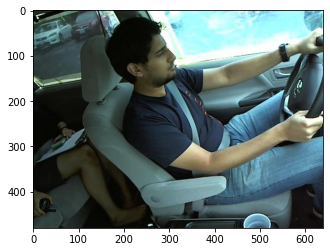

In [ ]:
from PIL import Image
for index in range(len(test_img_list)):
  cls = test.iloc[index]['classname']
  
  print("Classname",cls)
  im_test = Image.open(train_dir+'Train_Images/'+test.iloc[index]['img'])
  plt.imshow(im_test)
  print(im_test.size)
  im_test = im_test.resize((224,224))
  print(type(im_test))
  cls = model_new.predict(np.array(im_test)/255)
  print(i)

In [ ]:
predict = model_new_1800_imgs.predict_generator(test_generator,steps = 32)

In [ ]:
predict.size

2892

In [ ]:
len(test_generator.classes)

300

In [ ]:
predict = model_new.predict_generator(test_generator,steps = nb_samples)
y_pred = np.argmax(predict, axis=1)
print(len(y_pred))
print(len(test_generator.classes))
confusion_matrix(test_generator.classes, y_pred)

print('Classification Report')
target_names = ['c0', 'c1', 'c2']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


964
300


ValueError: ignored

**Section: PCA on single image**


In [ ]:
from matplotlib.image import imread
import matplotlib.pyplot as plt

image_raw = cv2.imread(train_dir+'/Train_Images/img_5.jpg')

(480, 640, 3)


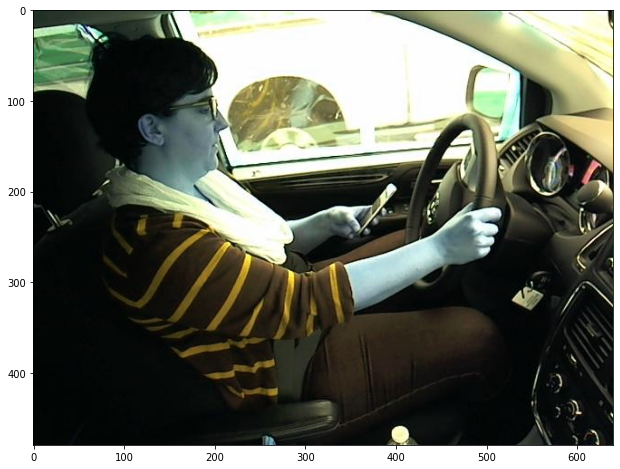

In [ ]:
print(image_raw.shape)

# Displaying the image
plt.figure(figsize=[12,8])
plt.imshow(image_raw)

In [ ]:
from skimage import color
imgGray = color.rgb2gray(image_raw)

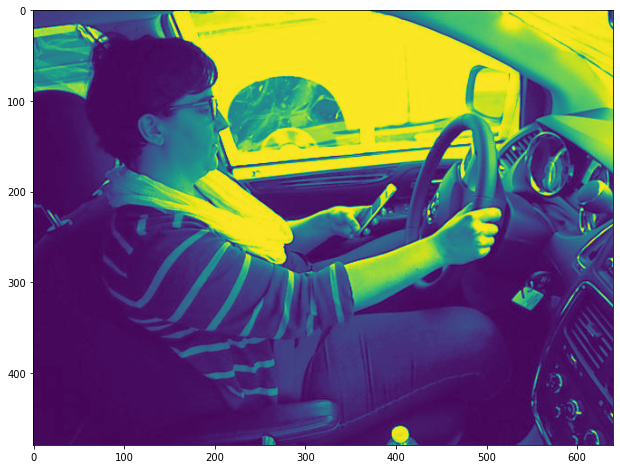

In [ ]:
plt.figure(figsize=[12,8])
plt.imshow(imgGray)

Number of components explaining 95% variance: 23


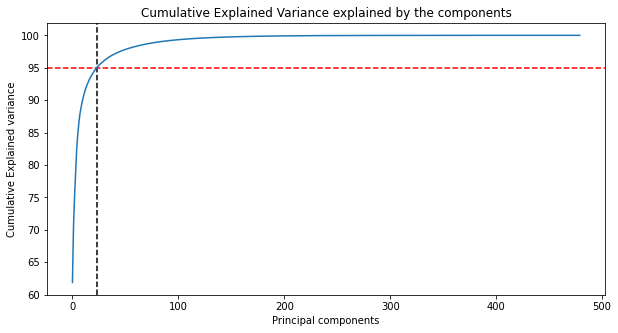

In [ ]:
#This section is not my code. Entire block is copy pasted from some location. I have added comments.
from sklearn.decomposition import PCA, IncrementalPCA
pca = PCA()
pca.fit(imgGray)

# Getting the cumulative variance

var_cumu = np.cumsum(pca.explained_variance_ratio_)*100

# How many PCs explain 95% of the variance?
k = np.argmax(var_cumu>95)
print("Number of components explaining 95% variance: "+ str(k))
#print("\n")

plt.figure(figsize=[10,5])
plt.title('Cumulative Explained Variance explained by the components')
plt.ylabel('Cumulative Explained variance')
plt.xlabel('Principal components')
plt.axvline(x=k, color="k", linestyle="--")
plt.axhline(y=95, color="r", linestyle="--")
ax = plt.plot(var_cumu)

In [ ]:
# Conclusion from above graph
# Looks like 23 components can explain 95% of the variance in the image!
# Next is to construct image with the limited number of components

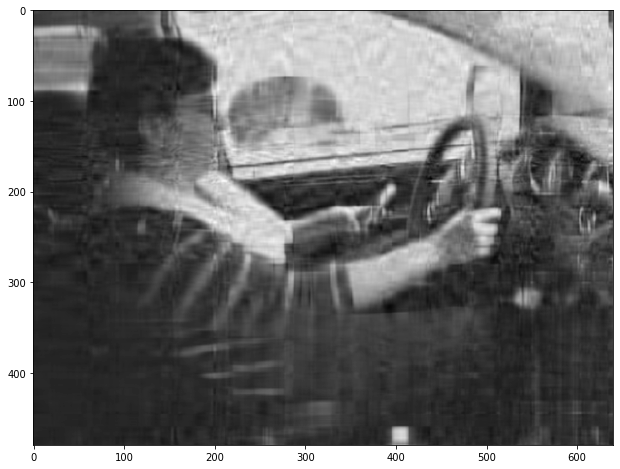

In [ ]:
#Using fit_transform method within the IncrementalPCA to first find 23 PCs.
# Tranfroming and representing data in those 38 new columns
ipca = IncrementalPCA(n_components=k)

#Reconstruct the orginal matrix from these 23 PCs.using inverse_transform
image_recon = ipca.inverse_transform(ipca.fit_transform(imgGray))

# Plotting the reconstructed image
plt.figure(figsize=[12,8])
plt.imshow(image_recon,cmap = plt.cm.gray)


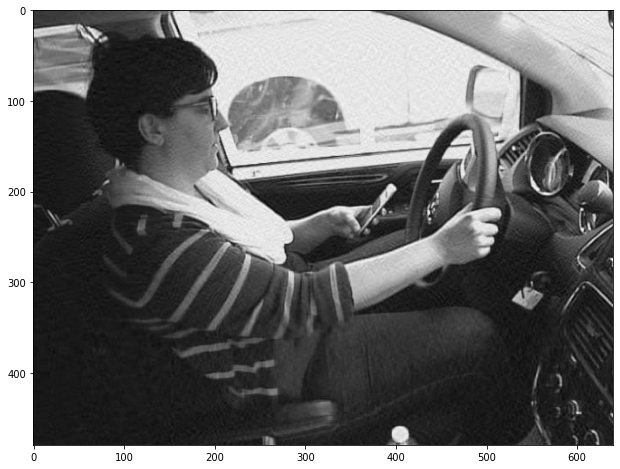

In [ ]:
# Writing above code in a function

def plot_at_k(image_g,k):
    ipca = IncrementalPCA(n_components=k)
    image_recon = ipca.inverse_transform(ipca.fit_transform(image_g))
    plt.imshow(image_recon,cmap = plt.cm.gray)
    return image_recon
    

k = 150
plt.figure(figsize=[12,8])
new_image = plot_at_k(imgGray,100)

In [ ]:
new_image.shape

(480, 640)

In [ ]:
# Applying PC as 150 to the entire Imagegenerator set. 
from sklearn.decomposition import PCA
pca = PCA(n_components=150)

In [ ]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(32,32,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(3, activation="softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 64)         

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [ ]:
model.fit_generator(train_generator, steps_per_epoch = 900/32,
                    validation_steps = 300/32,
                         epochs = 10,
                         validation_data = validate_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
28/28 [==============================] - 87s 3s/step - loss: 0.0101 - accuracy: 0.9967 - val_loss: 0.0338 - val_accuracy: 0.9933
Epoch 2/10
28/28 [==============================] - 10s 358ms/step - loss: 0.0034 - accuracy: 0.9978 - val_loss: 0.0940 - val_accuracy: 0.9867
Epoch 3/10
28/28 [==============================] - 10s 358ms/step - loss: 0.0060 - accuracy: 0.9989 - val_loss: 0.0280 - val_accuracy: 0.9933
Epoch 4/10
28/28 [==============================] - 10s 362ms/step - loss: 0.0208 - accuracy: 0.9967 - val_loss: 0.0276 - val_accuracy: 0.9933
Epoch 5/10
28/28 [==============================] - 10s 358ms/step - loss: 0.0443 - accuracy: 0.9922 - val_loss: 0.0317 - val_accuracy: 0.9933
Epoch 6/10
28/28 [==============================] - 9s 347ms/step - loss: 0.0245 - accuracy: 0.9967 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 7/10
28/28 [==============================] - 10s 354ms/step - loss: 0.0015 - accuracy: 0.9989 - val_loss: 0.0025 - val_accuracy: 0.9967
Epo

In [ ]:
model.save(source_dir+"first_model.h5")

In [ ]:
out = model.layers[-2].output
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='dense_4/Relu:0', description="created by layer 'dense_4'")


In [ ]:
second_last_layer_model = Model(inputs=model.input,
                                     outputs=model.layers[-2].output)


img = second_last_layer_model.predict()

(480, 640, 3)


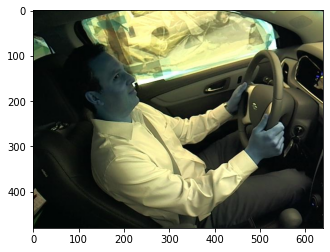

In [ ]:
img_array = cv2.imread(os.path.join(train_dir,'img_800.jpg'))
print(img_array.shape)
plt.imshow(img_array)

(32, 128)


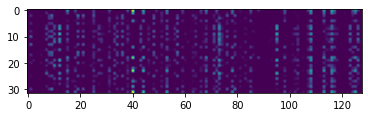

In [ ]:
layer_output=model.layers[-2].output

intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=layer_output)

intermediate_prediction=intermediate_model.predict(data_list[0])


row_size=4
col_size=8
  
img_index=0

print(np.shape(intermediate_prediction))
  

plt.imshow(intermediate_prediction)


#pca = PCA(n_components=150)
#a = PCA.fit(intermediate_prediction)

In [ ]:
layer_output

<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dense_4')>

In [ ]:

pre = model.predict(data_list[0])
pre

array([[2.5229152e-30, 0.0000000e+00, 1.0000000e+00],
       [5.6385097e-19, 3.5329755e-26, 1.0000000e+00],
       [4.7331798e-20, 1.0000000e+00, 2.6032238e-08],
       [4.2331529e-08, 1.0000000e+00, 1.6396640e-08],
       [1.4924929e-15, 5.8224271e-18, 1.0000000e+00],
       [1.1226103e-09, 9.9999952e-01, 5.2775329e-07],
       [1.0000000e+00, 1.7572374e-24, 8.4492266e-23],
       [1.0000000e+00, 5.1157731e-29, 1.6796395e-27],
       [8.9553338e-15, 1.0000000e+00, 1.4795537e-08],
       [1.0000000e+00, 6.6876696e-36, 3.0483225e-34],
       [9.2519503e-15, 1.0000000e+00, 1.4830583e-14],
       [1.0000000e+00, 2.3958939e-30, 2.8625287e-28],
       [1.0000000e+00, 2.5242551e-21, 7.4701065e-24],
       [1.1240981e-16, 1.0000000e+00, 6.7477022e-16],
       [7.1325117e-17, 3.1550621e-18, 1.0000000e+00],
       [1.0000000e+00, 4.8987129e-18, 8.2711004e-20],
       [4.2914244e-16, 1.0000000e+00, 3.1220190e-10],
       [4.9266244e-15, 1.0000000e+00, 2.6766587e-08],
       [2.9602335e-26, 1.015

In [ ]:
def visualize_pca_conv_layer(layer_name):
  
  layer_output=model.layers[-2].output

  intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=layer_output)

  intermediate_prediction=intermediate_model.predict([2].reshape(1,28,28,1))
  
  row_size=4
  col_size=8
  
  img_index=0

  print(np.shape(intermediate_prediction))
  
  fig,ax=plt.subplots(row_size,col_size,figsize=(10,8))

  for row in range(0,row_size):
    for col in range(0,col_size):
      ax[row][col].imshow(intermediate_prediction[0, :, :, img_index], cmap='gray')

      img_index=img_index+1

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 150)

In [ ]:
pca.fit()

TypeError: ignored

In [ ]:
def get_test_images_data(batch_size,generator):
    data_list = []
    for i in range(batch_size):
        data = generator.next()
        data_list.append(data[0])

    return data_list    

In [ ]:
data_list = get_test_images_data(6,test_generator)

In [ ]:
len(data_list)

6

In [ ]:
import sys
y_true_list = np.array([])
y_pred_list = np.array([])
for batch in range(len(data_list)):

  predict = model_new.predict(data_list[batch])
  y_pred = np.argmax(predict, axis=1)

  sys.stdout.flush()
  if len(y_pred_list) == 0:
      y_pred_list = np.array(y_pred)
  else:
      y_pred_list = np.append(y_pred_list, y_pred, axis=0)
  print(type(y_pred))

  if len(y_true_list) == 0:
      y_true_list = np.array(test_generator.classes[0:len(y_pred)])
  else:
      y_true_list = np.append(y_true_list, test_generator.classes[0:len(y_pred)], axis=0)
  #y_pred_list.append(y_pred)
  #y_true.append(test_generator.classes[0:len(y_pred)])

  #print(len(y_pred))
  #print(len(test_generator.classes[0:len(y_pred)]))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:

confusion_matrix(y_true_list, y_pred_list)

print('Classification Report')
target_names = ['c0', 'c1', 'c2']
print(classification_report(y_true_list, y_pred_list, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

          c0       0.22      0.40      0.28        48
          c1       0.25      0.15      0.19        66
          c2       0.37      0.31      0.34        78

    accuracy                           0.28       192
   macro avg       0.28      0.29      0.27       192
weighted avg       0.29      0.28      0.27       192



/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


KeyboardInterrupt: ignored

In [ ]:
import tensorflow as tf
model_dense_784 = tf.keras.Model(inputs=model.input, outputs = model.layers[1].output)



pred_dense_784 = model_dense_784.predict(train_generator, steps = 5) # predict_generator is deprecated

print(pred_dense_784.shape)

RuntimeError: ignored

In [ ]:
from keras import backend as K
outputs = []
for layer in model.layers:
    keras_function = K.function([model.input], [layer.output])
    outputs.append(keras_function([train_generator, 1]))
print(outputs)

TypeError: ignored

In [ ]:
pca.fit(train_generator)

KeyboardInterrupt: ignored

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1.0/255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   validation_split = 0.2)

training_set = train_datagen.flow_from_directory(train_dir, 
                                                 target_size = (240, 240), 
                                                 batch_size = 32,
                                                 subset = 'training',class_mode = "categorical")

validation_set = train_datagen.flow_from_directory(train_dir, 
                                                   target_size = (240, 240), 
                                                   batch_size = 32,
                                                   subset = 'validation',class_mode = "categorical")

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [ ]:

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

In [ ]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(240,240,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 240, 240, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 120, 120, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 120, 120, 32)      9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 30, 64)       

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.fit_generator(training_set, steps_per_epoch = 17943/32,
                         epochs = 10,
                         validation_data = validation_set,
                    validation_steps = 4481/32 )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
560/560 [==============================] - 5705s 10s/step - loss: 1.3785 - accuracy: 0.5203 - val_loss: 0.6036 - val_accuracy: 0.7969
Epoch 2/10
560/560 [==============================] - 1545s 3s/step - loss: 0.4525 - accuracy: 0.8555 - val_loss: 0.2965 - val_accuracy: 0.9101
Epoch 3/10
560/560 [==============================] - 1546s 3s/step - loss: 0.2827 - accuracy: 0.9123 - val_loss: 0.1838 - val_accuracy: 0.9440
Epoch 4/10
560/560 [==============================] - 1547s 3s/step - loss: 0.2004 - accuracy: 0.9361 - val_loss: 0.1694 - val_accuracy: 0.9478
Epoch 5/10
560/560 [==============================] - 1549s 3s/step - loss: 0.1595 - accuracy: 0.9481 - val_loss: 0.1560 - val_accuracy: 0.9534
Epoch 6/10
560/560 [==============================] - 1566s 3s/step - loss: 0.1450 - accuracy: 0.9551 - val_loss: 0.1108 - val_accuracy: 0.9670
Epoch 7/10
560/560 [==============================] - 1566s 3s/step - loss: 0.1259 - accuracy: 0.9604 - val_loss: 0.1202 - val_accuracy

Image Size (480, 640)


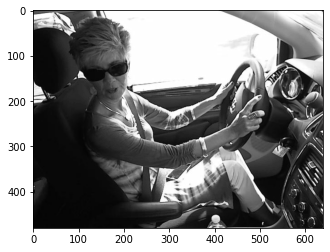

Image Size (480, 640)


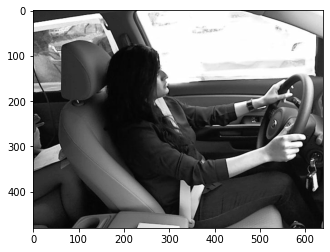

In [ ]:
cnt = 0
for i in classes:
    path = os.path.join(train_dir,i)
    for img in os.listdir(path):
        cnt = cnt+1
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        print('Image Size',img_array.shape)
        plt.imshow(img_array, cmap='gray')
        plt.show()
        if cnt == 2:
          break
    break

In [ ]:
def process_image(img):
  img_size = (250,250) 
  img_read = cv2.resize(img,img_size)
  #print(type(img_read))
  return img_read

In [ ]:
from glob import glob

def get_data():
    train_array = []
    for x in classes:
        images_in_class = glob(f'{train_dir}{x}/*.jpg')
        
        for i in range(len(images_in_class)):
          image_array = cv2.imread(images_in_class[i])
          resized_img = process_image(image_array)
          train_array.append([resized_img,x])
        print(x)
        
    return train_array

In [ ]:
len(classes)

10

In [ ]:
train_data = get_data()




KeyboardInterrupt: ignored

In [ ]:
print(len(train_data))

NameError: ignored

In [ ]:
x_train=[]
y_train=[]
for feature, label in train_data:
  x_train.append(feature)
  y_train.append(label)

In [ ]:
 from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.33, random_state=42)

X_train = np.array(X_train)
X_test = np.arrat(X_test)

ValueError: ignored

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [ ]:
opt = Adam(lr=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
from sklearn.preprocessing import LabelEncoder  

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [ ]:
history = model.fit(X_train,y_train,epochs = 500 , validation_data = (X_test, y_test))

Epoch 1/500
3/3 [==============================] - ETA: 0s - loss: 37.1353 - accuracy: 0.0746

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


3/3 [==============================] - 6s 2s/step - loss: 37.1353 - accuracy: 0.0746 - val_loss: 21.9215 - val_accuracy: 0.0606
Epoch 2/500
3/3 [==============================] - 6s 2s/step - loss: 34.3670 - accuracy: 0.1642 - val_loss: 19.2111 - val_accuracy: 0.0909
Epoch 3/500
3/3 [==============================] - 6s 2s/step - loss: 35.9418 - accuracy: 0.0746 - val_loss: 17.2825 - val_accuracy: 0.1212
Epoch 4/500
3/3 [==============================] - 6s 2s/step - loss: 33.2263 - accuracy: 0.0746 - val_loss: 16.1523 - val_accuracy: 0.1818
Epoch 5/500
3/3 [==============================] - 6s 2s/step - loss: 30.3680 - accuracy: 0.0896 - val_loss: 15.5831 - val_accuracy: 0.1818
Epoch 6/500
3/3 [==============================] - 6s 2s/step - loss: 29.9537 - accuracy: 0.1343 - val_loss: 15.2203 - val_accuracy: 0.1818
Epoch 7/500
3/3 [==============================] - 6s 2s/step - loss: 30.7562 - accuracy: 0.0597 - val_loss: 15.1769 - val_accuracy: 0.1515
Epoch 8/500
3/3 [===============

In [ ]:
len(train_data)

100

In [ ]:
print(len(X_test),y_train[0])

33 c2


In [ ]:
import pandas as pd
driver_imgs_list = pd.read_csv('gdrive/MyDrive/DistractedDriver/driver_imgs_list.csv')

In [ ]:
driver_imgs_list.head()

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

In [ ]:
 driver_imgs_list.describe()

subject classname            img
count    22424     22424          22424
unique      26        10          22424
top       p021        c0  img_63085.jpg
freq      1237      2489              1

In [ ]:
#train_list = list()
#    for x in classes:
        #f, ax = plt.subplots(figsize=(12, 10))
#        images_in_class = glob(f'{train_dir}{x}/*.jpg')

 
#       for i in range(9):
          
          #plt.subplot(4,4,i+1)
          #print(images_in_class[i])
 #         image_array = cv2.imread(images_in_class[i])
   #       train_list.append([image_array,x])
          #plt.imshow(image)
          #plt.axis('off')
  #      print(x)
        #plt.show()
   #     print('##################################################')  

In [ ]:
driver_imgs_list['classname'].value_counts()

c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: classname, dtype: int64

In [ ]:
import shutil
import os
  
# Define the source and destination path
destination = "gdrive/MyDrive/DistractedDriver/imgs/train/"
source = destination + "Images/"
  
# code to move the files from sub-folder to main folder.
files = os.listdir(source)
for file in files:
    file_name = os.path.join(source, file)
    shutil.move(file_name, destination)
print("Files Moved")

Files Moved


In [ ]:
def moveFiles(path, disdir): # path is the original path, disdir is the target directory of the move
    dirlist = os.listdir(path)
    for i in dirlist:
        child = os.path.join('%s%s' % (path, i))
        print(child)
        for file in child:
          file_name = os.path.join(source, file)
          print(file_name)
          shutil.move(file_name, destination)

source = "gdrive/MyDrive/DistractedDriver/imgs/train/"
destination = source + "Images/"

moveFiles(source,destination)

gdrive/MyDrive/DistractedDriver/imgs/train/c0
gdrive/MyDrive/DistractedDriver/imgs/train/g


FileNotFoundError: ignored

In [ ]:
# Source path 

destination = "gdrive/MyDrive/DistractedDriver/imgs/train/Images/"
source = "gdrive/MyDrive/DistractedDriver/imgs/train/c0"

file_names = os.listdir(source_dir)
    
for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), destination)
  
# Move the content of 
# source to destination 
#dest = shutil.move(source, destination) 
  

Error: ignored

In [ ]:
input = "gdrive/MyDrive/DistractedDriver/imgs/train/c9"
output = "gdrive/MyDrive/DistractedDriver/imgs/train/Train_Images/"
 
for dirpath, dirnames, filenames in os.walk(input):
    for filename in filenames:
            shutil.move(input+'/'+filename, output)